In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell
import random

# Hyperparameters

In [2]:
train_length = 1000
test_length = 1500

discount_rate = 0.995
rnn_size = 10

sampling_rate = 200
striding = 100
train_steps = 1000

In [3]:
def downgrade_and_feature(array):
    nchannels = array.shape[0]
    data_length = array.shape[1]
    
    temp = np.zeros(data_length)
    
    for j in range(data_length):
        for i in range(nchannels):
            temp[j] += array[i][j]
        temp[j]/=nchannels
    
    reduced_length = int(data_length/striding)

    averages = np.zeros(reduced_length, dtype = np.float32)   
    variations = np.zeros(reduced_length, dtype = np.float32)
    
    for i in range(reduced_length):
        averages[i] = np.average(temp[striding*i:striding*(i+1)])
        variations[i] = np.var(temp[striding*i:striding*(i+1)])
        
    return {'averages' : averages,'variations' : variations}

In [4]:
def dataload(patient_number, dataset_number):
    try :
        input_folder_path = '/home/maestroj/medical_analysis/eeg_csv'
        input_data_name = 'data{}_{}.csv'.format(patient_number,dataset_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [5]:
def normal_data_load(patient_number, iswakeup=0):
    try :
        input_folder_path = '/home/maestroj/medical_analysis/eeg_normal'
        input_data_name = 'data{}xs.csv'.format(patient_number)
        if iswakeup == 1:
            input_data_name = 'data{}w.csv'.format(patient_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [6]:
def time_axis_maker(array, sec_per_cell,init = 0):
    final = init + sec_per_cell*(len(array)-1)
    return np.linspace(init,final,len(array))

# Onset-time data

In [7]:
def seizure_time_parser(onset_times,patient_number,data_set_number):
    temp = str(onset_times[patient_number-1][data_set_number])
    curr_onset_time = []
    while temp.find('/')!=-1:
        curr_onset_time.append(int(temp[0:temp.find('/')]))
        temp=temp[temp.find('/')+1:]
    curr_onset_time.append(int(float(temp)))
    curr_onset_time=np.array(curr_onset_time)
    return curr_onset_time

In [8]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times_temp=[]

for row in reader:
    onset_times_temp.append(row)
    
onset_times = []
total_patient = len(onset_times_temp)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]

for i in range(total_patient):
    event_number[i] = len(onset_times_temp[i])-1

for p in range(total_patient):
    temp = []
    for d in range(event_number[p]):
        temp.append(seizure_time_parser(onset_times_temp,p+1,d+1))
    onset_times.append(temp)

In [9]:
print("The number of datasets of patients")
print(event_number)
print("1st patient's seizure time for each data_set")
print(onset_times[0][1])
print("9th patient's seizure time for each data_set")
print(onset_times[8])

The number of datasets of patients
[ 7  7  6  3 10  1  7 13 16  8  8  5  3  6 31  8  2  4]
1st patient's seizure time for each data_set
[781]
9th patient's seizure time for each data_set
[array([200]), array([312]), array([624]), array([762]), array([752]), array([772]), array([884]), array([502]), array([ 94, 258]), array([836]), array([650]), array([636]), array([576]), array([656]), array([638]), array([706])]


In [10]:
temp = dataload(1,1)
print(temp.shape)
result = downgrade_and_feature(temp)
print(result['averages'].shape)
print(result['variations'].shape)
time = time_axis_maker(result['averages'], striding/sampling_rate)

data1_1.csv is loaded
(22, 315200)
(3152,)
(3152,)


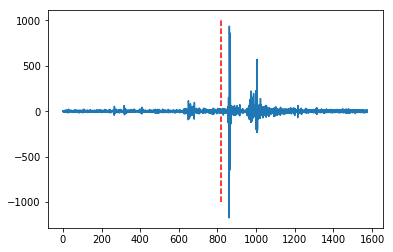

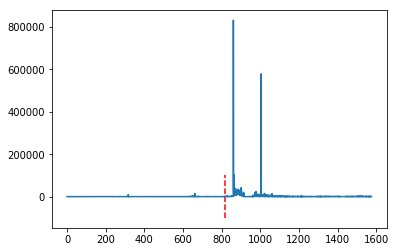

In [11]:
plt.plot(time, result['averages'])
plt.vlines(onset_times[0][0], -1000, 1000, colors='r', linestyles='--')
plt.show()

plt.plot(time, result['variations'])
plt.vlines(onset_times[0][0], -100000, 100000, colors='r', linestyles='--')
plt.show()

# Training_set

In [12]:
def train_set_generator(patient_number, dataset_number):
    temp = dataload(patient_number,dataset_number)
    if len(temp)==0:
        return
    result = downgrade_and_feature(temp)
    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        

    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    onset_time_temp = onset_time_temp[0]
    
    if onset_time_temp*sampling_rate/striding < train_length:
        print("Wrong input")
        return
    
    input_data = np.zeros((2,train_length))
    output_data = np.zeros(train_length)
    
    for i in range(train_length):
        if i==0:
            output_data[train_length-1] = 1
        else :
            output_data[train_length-1-i] = discount_rate*output_data[train_length-i] 

    onset_on_array = int(onset_time_temp*sampling_rate/striding)
    
    for i in range(train_length):
        input_data[0][i] = result['averages'][onset_on_array-train_length+1+i]
        input_data[1][i] = result['variations'][onset_on_array-train_length+1+i]

    return {'input' : input_data, 'output' : output_data}

In [13]:
def train_set_generator2(patient_number, iswakeup=0):
    temp = normal_data_load(patient_number,iswakeup)
    if len(temp)==0:
        return
    result = downgrade_and_feature(temp)
    original_length = len(result['averages'])
    input_data = np.zeros((2,train_length))
    output_data = np.zeros(train_length)
    for i in range(train_length):
        index = i%original_length
        input_data[0][i] = result['averages'][index]
        input_data[1][i] = result['variations'][index]
    return {'input' : input_data, 'output' : output_data}

data1_1.csv is loaded


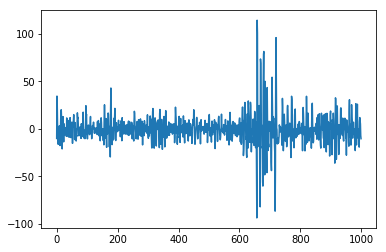

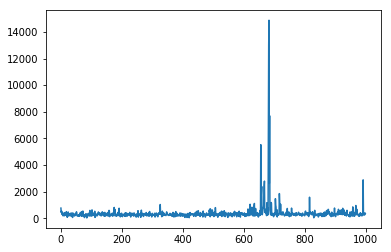

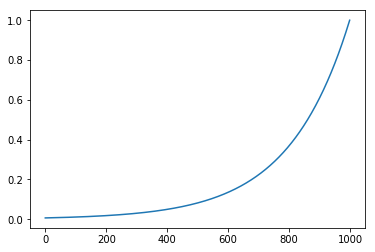

(2, 1000)
(1000,)


In [ ]:
result = train_set_generator(1,1)
plt.plot(result['input'][0])
plt.show()
plt.plot(result['input'][1])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

In [ ]:
train_input_data = []
train_output_data = []

for i in range(len(onset_times)):
    for j in range(len(onset_times[i])):
        if len(onset_times[i][j])>1:
            continue;
        onset_time_temp = onset_times[i][j][0]
        if onset_time_temp*sampling_rate/striding < train_length:
            continue;
        print("Patient {} and dataset {}".format(i+1,j+1))
        result = train_set_generator(i+1, j+1)
        input_data = result['input']
        output_data = result['output']
        
        prob = random.random()
        
        if prob<0.8:
            train_input_data.append(input_data)
            train_output_data.append(output_data)

        normal_number = i%10+1
        iswakeup = j%2

        result = train_set_generator2(normal_number, iswakeup)
        if result == None:
            continue;
        input_data = result['input']
        output_data = result['output']
        if prob<0.8:
            train_input_data.append(input_data)
            train_output_data.append(output_data)
            
train_input_data = np.array(train_input_data)
train_output_data = np.array(train_output_data)

Patient 1 and dataset 1
data1_1.csv is loaded
No such File
Patient 1 and dataset 2
data1_2.csv is loaded
data1w.csv is loaded
Patient 1 and dataset 3
data1_3.csv is loaded
No such File
Patient 1 and dataset 4
data1_4.csv is loaded
data1w.csv is loaded
Patient 1 and dataset 5
data1_5.csv is loaded
No such File
Patient 1 and dataset 6
data1_6.csv is loaded
data1w.csv is loaded
Patient 1 and dataset 7
data1_7.csv is loaded
No such File
Patient 2 and dataset 1
data2_1.csv is loaded
No such File
Patient 2 and dataset 2
data2_2.csv is loaded
data2w.csv is loaded
Patient 2 and dataset 3
data2_3.csv is loaded
No such File
Patient 2 and dataset 4
data2_4.csv is loaded
data2w.csv is loaded
Patient 2 and dataset 5
data2_5.csv is loaded
No such File
Patient 2 and dataset 6
data2_6.csv is loaded
data2w.csv is loaded
Patient 2 and dataset 7
data2_7.csv is loaded
No such File
Patient 3 and dataset 1
data3_1.csv is loaded
No such File
Patient 3 and dataset 5
data3_5.csv is loaded
No such File
Patient 

In [ ]:
print(train_input_data.shape)
print(train_output_data.shape)
print(len(train_input_data))
temp1 = np.transpose(train_input_data,[1,2,0])
print(temp1.shape)
temp2 = np.transpose(train_output_data,[1,0])
print(temp2.shape)

In [ ]:
output_file_name1 = 'rnn_v6_input_average.csv'
output_file_name2 = 'rnn_v6_input_variation.csv'
output_file_name3 = 'rnn_v6_output.csv'

csv_file = open(output_file_name1, "w")
cw = csv.writer(csv_file , delimiter=',')
size = train_length
for i in range(size):
    row =   temp1[0][i]
    cw.writerow(row)

csv_file = open(output_file_name2, "w")
cw = csv.writer(csv_file , delimiter=',')
for i in range(size):
    row =   temp1[1][i]
    cw.writerow(row)
    
csv_file = open(output_file_name3, "w")
cw = csv.writer(csv_file , delimiter=',')
for i in range(size):
    row =   temp2[i]
    cw.writerow(row)